In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
path = "/content/drive/My Drive/"
os.chdir(path)
os.listdir(path)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import norm
import math
from scipy.linalg import sqrtm
import numba as nb


In [4]:
mu1 = 0.004;
sigma1 = 0.04;
mu2 = 0.006;
sigma2 = 0.05;
#Number of simlations.
num_sim = 1000000;
#np.random.seed(10)

In [5]:
@nb.jit(nopython=True)
def cal_total_loss():
  total_loss = np.zeros((num_sim,3))
  total_loss
  for i in range(num_sim):
    z1=np.random.normal(0,1)
    z2=np.random.normal(0,1)
    norm1=np.random.normal(0,1,25)
    norm2=np.random.normal(0,1,25)
    x1_tilde=np.sum(mu1+(np.sqrt(0.3)*z1+np.sqrt(1-0.3)*norm1)*sigma1)
    x2_tilde=np.sum(mu2+(np.sqrt(0.1)*z2+np.sqrt(1-0.1)*norm2)*sigma2)
    x_tilde=x1_tilde+x2_tilde
    total_loss[i][0]=x1_tilde
    total_loss[i][1]=x2_tilde
    total_loss[i][2]=x_tilde
  return total_loss

In [6]:
total_loss=cal_total_loss()
all_data=np.sort(total_loss[:,2])
alpha_VaR=0.99
ten_VaR=all_data[math.ceil(num_sim*alpha_VaR)]

alpha_ES=0.975
ten_ES=(1/(num_sim*(1-alpha_ES)))*(np.sum(all_data[math.ceil(num_sim*alpha_ES)+1:num_sim])+(math.ceil(num_sim*alpha_ES)-num_sim*alpha_ES)*all_data[math.ceil(num_sim*alpha_ES)])
print("Ten day VaR(alpha = 0.99):",ten_VaR)
print('Ten day ES(alpha = 0.975)',ten_ES)

epsilon=0.01

x1_allocation_VaR=np.mean([x[0] for x in total_loss[:,:] if (x[2]>ten_VaR-epsilon)&(x[2]<ten_VaR+epsilon)])
x2_allocation_VaR=np.mean([x[1] for x in total_loss[:,:] if (x[2]>ten_VaR-epsilon)&(x[2]<ten_VaR+epsilon)])


print('Euler allocations for VaR for X1_tilde',x1_allocation_VaR)
print('Euler allocations for VaR for X2_tilde',x2_allocation_VaR)

new_VaR=all_data[math.ceil(num_sim*alpha_ES)]
x1_allocation_ES=np.mean([x[0] for x in total_loss[:,:] if (x[2]>=new_VaR)])
x2_allocation_ES=np.mean([x[1] for x in total_loss[:,:] if (x[2]>=new_VaR)])

print('Euler allocations for ES for X1_tilde',x1_allocation_ES)
print('Euler allocations for ES for X2_tilde',x2_allocation_ES)

Ten day VaR(alpha = 0.99): 1.957821744162239
Ten day ES(alpha = 0.975) 1.966909965572091
Euler allocations for VaR for X1_tilde 1.1276328361742736
Euler allocations for VaR for X2_tilde 0.8297601859916571
Euler allocations for ES for X1_tilde 1.1435773904584705
Euler allocations for ES for X2_tilde 0.8234000936928978


# FRTB

In [7]:
@nb.jit(nopython=True)
def cal_frtb():
  #X1_frtb=np.zeros(num_sim*5*5)
  #X1_frtb=X1_frtb.reshape(num_sim,5,5)
  #X2_frtb=np.zeros(num_sim*5*5)
  #X2_frtb=X2_frtb.reshape(num_sim,5,5)
  X1_frtb = []
  X2_frtb = []
  for N in range(num_sim):
      # X1
      X1_ij = np.zeros((5,5))
      z1=np.random.normal(0,1)
      for i in range(0, 5):
        norm1=np.random.normal(0,1,5)
        X1_ij_telta = mu1+(np.sqrt(0.3)*z1+np.sqrt(1-0.3)*norm1)*sigma1
        X1_ij[i][0]= np.sqrt((10-0)/10)*np.sum(X1_ij_telta)
        X1_ij[i][1]= np.sqrt((20-10)/10)*np.sum(X1_ij_telta[1:])
        X1_ij[i][2]= np.sqrt((40-20)/10)*np.sum(X1_ij_telta[2:])
        X1_ij[i][3]= np.sqrt((60-40)/10)*np.sum(X1_ij_telta[3:])
        X1_ij[i][4]= np.sqrt((120-60)/10)*np.sum(X1_ij_telta[4:])
      X1_frtb.append(X1_ij)

      # X2
      X2_ij = np.zeros((5,5))
      z2=np.random.normal(0,1)
      for i in range(0, 5):
        norm2=np.random.normal(0,1,5)
        X2_ij_telta = mu2+(np.sqrt(0.1)*z2+np.sqrt(1-0.1)*norm2)*sigma2
        X2_ij[i][0] = np.sqrt((10-0)/10)*np.sum(X2_ij_telta)
        X2_ij[i][1] = np.sqrt((20-10)/10)*np.sum(X2_ij_telta[1:])
        X2_ij[i][2] = np.sqrt((40-20)/10)*np.sum(X2_ij_telta[2:])
        X2_ij[i][3] = np.sqrt((60-40)/10)*np.sum(X2_ij_telta[3:])
        X2_ij[i][4] = np.sqrt((120-60)/10)*np.sum(X2_ij_telta[4:])
      X2_frtb.append(X2_ij)
  #Total=X1_frtb+X2_frtb
  return X1_frtb,X2_frtb

x=cal_frtb()
X1_frtb=np.array(x[0])
X2_frtb=np.array(x[1])
Total = X1_frtb+X2_frtb

In [8]:
ESIJ_5= np.zeros((5,5))
alpha_ES=0.975
ES=[]
k = int(num_sim*alpha_ES)
for i in range(5):
  ESi_j_squared = []
  for j in range(5):
    data=Total[:,i,j]
    all_data_ij=np.sort(data)
    #temp=(1/(num_sim*(1-alpha_ES)))*(np.sum(all_data_ij[math.ceil(num_sim*alpha_ES)+1:num_sim])+(math.ceil(num_sim*alpha_ES)-num_sim*alpha_ES)*all_data_ij[math.ceil(num_sim*alpha_ES)-1])#q确定i和j，n次模拟下ij结果
    temp = 1/(num_sim*(1-alpha_ES))*np.sum(all_data_ij[k:])
    ESIJ_5[i][j] = temp
    ESi_j_squared.append(temp**2)
  ES.append(np.sqrt(np.sum(ESi_j_squared)))
print("The FRTB ES is:\n",ES)
print("All ES(i=5,j=5):\n",ESIJ_5)

The FRTB ES is:
 [0.9527805569672824, 0.9512923850612647, 0.9518838233932342, 0.9530072618051987, 0.9528848647870216]
All ES(i=5,j=5):
 [[0.48821682 0.41141843 0.46993793 0.35389728 0.39253669]
 [0.48784668 0.41060585 0.46943352 0.35375224 0.39096953]
 [0.488161   0.41142463 0.46973982 0.35310679 0.39137134]
 [0.48884479 0.41141315 0.47028649 0.3537599  0.39201707]
 [0.48901449 0.41177982 0.47047447 0.35357317 0.39106465]]


In [9]:
#task 8
IMCC=[x*2 for x in ES]
print("The FRTB ES Carpital Charge is:",IMCC)

The FRTB ES Carpital Charge is: [1.9055611139345647, 1.9025847701225294, 1.9037676467864684, 1.9060145236103974, 1.9057697295740432]


In [10]:
@nb.jit()
def cal_X6():
  N=len(Total)
  X6_1=[]
  X6_2=[]
  X6=[]
  for n in range(N):
    temp_1 = []
    temp_2 = []
    temp=[]
    for j in range(5):
      X1_6j=X1_frtb[n][:,j].sum()
      X2_6j=X2_frtb[n][:,j].sum()
      temp_1.append(X1_6j)
      temp_2.append(X2_6j)
      X_6j=X1_6j+X2_6j
      temp.append(X_6j)
    X6.append(temp)
    X6_1.append(temp_1)
    X6_2.append(temp_2)
  X6_1 = np.array(X6_1)
  X6_2 = np.array(X6_2)
  X6=np.array(X6)
  return X6_1,X6_2,X6
a=cal_X6()   
X61=a[0]
X62=a[1]
X6=a[2]
Total2 =np.zeros(num_sim*5*6)
Total2=Total2.reshape(num_sim,6,5)
for i in range(0, len(Total)):
  temp = np.row_stack((Total[i], X6[i]))
  Total2[i]=temp

In [11]:
ES6=[]
ESIJ_6=[]
for i in range(6):
  ESi_j=[]
  for j in range(5):
    data=Total2[:,i,j]
    all_data_ij=np.sort(data)
    num_sim=len(Total2)
    ESij_=(1/(num_sim*(1-alpha_ES)))*(np.sum(all_data_ij[math.ceil(num_sim*alpha_ES)+1:num_sim])+(math.ceil(num_sim*alpha_ES)-num_sim*alpha_ES)*all_data_ij[math.ceil(num_sim*alpha_ES)-1])#q确定i和j，n次模拟下ij结果
    ESi_j.append(ESij_**2)
  ESIJ_6.append(ESi_j)
  ES6.append(np.sqrt(np.sum(ESi_j)))
ESIJ_6=np.array(ESIJ_6)
print("The FRTB ES(6) is:",ES6)
print("All ES(i=6,j=5) is:\n",ESIJ_6)

The FRTB ES(6) is: [0.9527480983851356, 0.9512599229266432, 0.9518513525305552, 0.9529747715490396, 0.9528523732900294, 3.522039792704252]
All ES(i=6,j=5) is:
 [[0.23833937 0.16925357 0.2208266  0.12523476 0.15407464]
 [0.23797811 0.16858563 0.22035279 0.12513213 0.15284679]
 [0.23828484 0.16925867 0.22064045 0.12467591 0.15316113]
 [0.23895289 0.16924923 0.2211543  0.12513754 0.15366696]
 [0.23911881 0.16955105 0.22133113 0.12500547 0.15292118]
 [3.87696288 2.56535953 3.03928874 1.49225034 1.43090281]]


# Task 10 
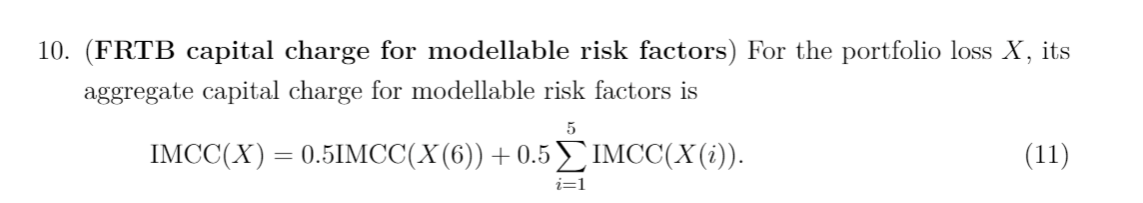

In [12]:
#task 10
IMCC=[x*2 for x in ES6]
print("The FRTB ES(6) Carpital Charge is:",IMCC)

The FRTB ES(6) Carpital Charge is: [1.9054961967702713, 1.9025198458532864, 1.9037027050611104, 1.9059495430980793, 1.9057047465800587, 7.044079585408504]


In [13]:
IMCC_X=0.5*IMCC[-1]+0.5*np.sum(IMCC[:-1])
IMCC_X

8.283726311385655

### **Item 12**
FRTB Euler allocation of X(i, j)

In [14]:
VaR_Xij=np.zeros(shape=(5,5))
Euler_alloc1=np.zeros(shape=(5,5))
Euler_alloc2=np.zeros(shape=(5,5))
for i in range(5):
  for j in range(5):
    data=Total[:,i,j]
    sort_data=np.sort(data)
    VaR_Xij[i][j]=sort_data[math.ceil(num_sim*0.975)]
    pos=np.where(data>=VaR_Xij[i][j])[0]
    Euler_alloc1[i][j]=np.mean(X1_frtb[pos][:,i,j])
    Euler_alloc2[i][j]=np.mean(X2_frtb[pos][:,i,j])
print('VaR_0.975(X(i,j)) given 1<i,j<5 is')
print(VaR_Xij)
print('ES(X_1(i,j)|X(i,j)),given 1<i,j<5 is')
print(Euler_alloc1)
print('ES(X_2(i,j)|X(i,j)),given 1<i,j<5 is')
print(Euler_alloc2)

VaR_0.975(X(i,j)) given 1<i,j<5 is
[[0.41704563 0.35105017 0.40061567 0.30130734 0.33172465]
 [0.41700067 0.35112061 0.40055735 0.30124357 0.33204463]
 [0.41780197 0.35102418 0.40064336 0.30086222 0.33191743]
 [0.41781246 0.35115767 0.40088345 0.3012058  0.33234603]
 [0.41815204 0.3514395  0.40103372 0.30110705 0.33160447]]
ES(X_1(i,j)|X(i,j)),given 1<i,j<5 is
[[0.2390844  0.19458963 0.21206364 0.15137229 0.15312443]
 [0.24085695 0.19600838 0.21454002 0.15224131 0.15315849]
 [0.24010536 0.19520625 0.21387823 0.15132431 0.15341897]
 [0.23985242 0.19501172 0.2140058  0.151621   0.15337406]
 [0.23945125 0.19508262 0.21419437 0.15064515 0.15284487]]
ES(X_2(i,j)|X(i,j)),given 1<i,j<5 is
[[0.24913241 0.2168288  0.2578743  0.20252499 0.23941226]
 [0.24698974 0.21459747 0.2548935  0.20151094 0.23781104]
 [0.24805564 0.21621837 0.25586159 0.20178248 0.23795237]
 [0.24899237 0.21640143 0.25628069 0.2021389  0.23864301]
 [0.24956323 0.2166972  0.2562801  0.20292802 0.23821978]]


### **item13**

In [15]:
ES_FC_X1 = np.zeros((5,5))
ES_FC_X2 = np.zeros((5,5))
for i in range(0, 5):
  for j in range(0, 5):
   ES_FC_X1[i,j] = ESIJ_5[i,j]/ES[i]*Euler_alloc1[i,j]
   ES_FC_X2[i,j] = ESIJ_5[i,j]/ES[i]*Euler_alloc2[i,j]


In [16]:
print('ES_FC_X1[i,j]')
print(ES_FC_X1)

ES_FC_X1[i,j]
[[0.12250988 0.08402539 0.1045957  0.05622516 0.06308584]
 [0.12351751 0.084603   0.1058689  0.0566132  0.06294627]
 [0.12313485 0.08437233 0.10554557 0.05613463 0.0630789 ]
 [0.12303223 0.08418654 0.10560679 0.05628229 0.06309002]
 [0.12288487 0.08430304 0.10575568 0.05589771 0.06272765]]


In [17]:
print('ES_FC_X2[i,j]')
print(ES_FC_X2)

ES_FC_X2[i,j]
[[0.1276586  0.09362845 0.12719079 0.07522513 0.09863561]
 [0.12666256 0.0926266  0.1257821  0.07493484 0.09773743]
 [0.12721205 0.09345422 0.12626371 0.07485237 0.09783519]
 [0.12772056 0.09342048 0.12646845 0.07503472 0.09816518]
 [0.12807427 0.09364356 0.12653496 0.07529756 0.09776557]]


In [18]:
ES

[0.9527805569672824,
 0.9512923850612647,
 0.9518838233932342,
 0.9530072618051987,
 0.9528848647870216]

In [19]:
np.sum(ES_FC_X1,axis=1)+np.sum(ES_FC_X2,axis=1)

array([0.95278056, 0.95129239, 0.95188382, 0.95300726, 0.95288486])

# Task 14

In [20]:
# task 14
ESFC_X_6_1=np.zeros(5)
ESFC_X_6_2=np.zeros(5)
for j in range(5):
  data=X6[:,j]
  pos=np.where(data>=np.percentile(data,97.5))[0]
  ESFC_X_6_1[j]=np.mean(X61[pos][:,j])
  ESFC_X_6_2[j]=np.mean(X62[pos][:,j])


ESFC_X6_1=np.sqrt(ESIJ_6[-1])/ES6[-1]*ESFC_X_6_1
ESFC_X6_2=np.sqrt(ESIJ_6[-1])/ES6[-1]*ESFC_X_6_2
print('ESFC(X1(6,j)|X(6))',ESFC_X6_1)
print('ESFC(X2(6,j)|X(6))',ESFC_X6_2)

ESFC(X1(6,j)|X(6)) [0.63936557 0.4156613  0.48258816 0.2271697  0.19943861]
ESFC(X2(6,j)|X(6)) [0.46144431 0.31273696 0.38037569 0.19653408 0.20684634]


#Task 15 Euler allocation of IMCC
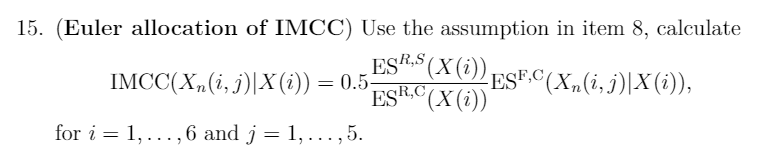

In [24]:
IMCC_X1_6=0.5*2*np.vstack((ES_FC_X1,ESFC_X6_1))
IMCC_X2_6=0.5*2*np.vstack((ES_FC_X1,ESFC_X6_2))
print("Item 15")
print("The Euler allocation of IMCC(IMCC(X1(i,j)|(X(i)))) is equal to: \n",IMCC_X1_6)
print("The Euler allocation of IMCC(IMCC(X2(i,j)|(X(i)))) is equal to: \n",IMCC_X2_6)

Item 15
The Euler allocation of IMCC(IMCC(X1(i,j)|(X(i)))) is equal to: 
 [[0.12250988 0.08402539 0.1045957  0.05622516 0.06308584]
 [0.12351751 0.084603   0.1058689  0.0566132  0.06294627]
 [0.12313485 0.08437233 0.10554557 0.05613463 0.0630789 ]
 [0.12303223 0.08418654 0.10560679 0.05628229 0.06309002]
 [0.12288487 0.08430304 0.10575568 0.05589771 0.06272765]
 [0.63936557 0.4156613  0.48258816 0.2271697  0.19943861]]
The Euler allocation of IMCC(IMCC(X2(i,j)|(X(i)))) is equal to: 
 [[0.12250988 0.08402539 0.1045957  0.05622516 0.06308584]
 [0.12351751 0.084603   0.1058689  0.0566132  0.06294627]
 [0.12313485 0.08437233 0.10554557 0.05613463 0.0630789 ]
 [0.12303223 0.08418654 0.10560679 0.05628229 0.06309002]
 [0.12288487 0.08430304 0.10575568 0.05589771 0.06272765]
 [0.46144431 0.31273696 0.38037569 0.19653408 0.20684634]]


# Task 16
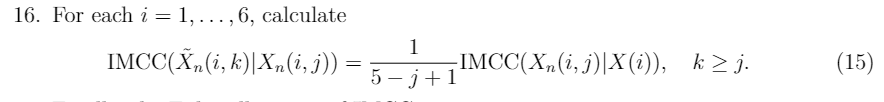

In [22]:
IMCC_X1_jk=np.zeros([6,5])
for j in range(5):
    IMCC_X1_jk[:,j]=IMCC_X1_6[:,j]/(5-j+1)
IMCC_X2_jk=np.zeros([6,5])
for j in range(5):
    IMCC_X2_jk[:,j]=IMCC_X2_6[:,j]/(5-j+1)

# Task 17
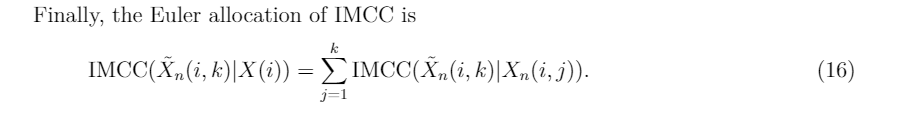

In [26]:
# Euler allocation of IMCC
IMCC_sum_1=np.cumsum(IMCC_X1_jk,axis=1)
print('IMCC Risk Position 1')
print(np.round(IMCC_sum_1,4))
IMCC_sum_2=np.cumsum(IMCC_X2_jk,axis=1)


IMCC Risk Position 1
[[0.0204 0.0372 0.0634 0.0821 0.1137]
 [0.0206 0.0375 0.064  0.0828 0.1143]
 [0.0205 0.0374 0.0638 0.0825 0.114 ]
 [0.0205 0.0373 0.0637 0.0825 0.1141]
 [0.0205 0.0373 0.0638 0.0824 0.1138]
 [0.1066 0.1897 0.3103 0.3861 0.4858]]


In [27]:
print('IMCC Risk Position 2')
print(np.round(IMCC_sum_2,4))


IMCC Risk Position 2
[[0.0204 0.0372 0.0634 0.0821 0.1137]
 [0.0206 0.0375 0.064  0.0828 0.1143]
 [0.0205 0.0374 0.0638 0.0825 0.114 ]
 [0.0205 0.0373 0.0637 0.0825 0.1141]
 [0.0205 0.0373 0.0638 0.0824 0.1138]
 [0.0769 0.1395 0.2345 0.3001 0.4035]]
